Run the following cell if on Google Colab to load Python modules

In [1]:
!wget https://raw.githubusercontent.com/karencfisher/forward-forward/main/models.py
!wget https://raw.githubusercontent.com/karencfisher/forward-forward/main/layers.py
!wget https://raw.githubusercontent.com/karencfisher/forward-forward/main/utils.py

--2023-02-20 14:47:51--  https://raw.githubusercontent.com/karencfisher/forward-forward/main/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2961 (2.9K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   2.89K  --.-KB/s    in 0s      

2023-02-20 14:47:51 (48.1 MB/s) - ‘models.py’ saved [2961/2961]

--2023-02-20 14:47:51--  https://raw.githubusercontent.com/karencfisher/forward-forward/main/layers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1613 (1.6K) [text/plain]
Saving to: ‘la

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean
from tensorflow.data import Dataset
import tensorflow as tf


import utils
from layers import FFDense
from models import FFNetwork

60000 training examples
10000 testing examples


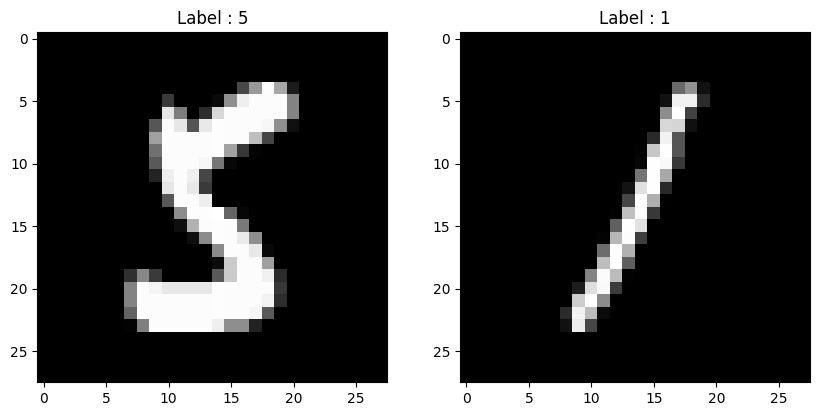

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(f'{x_train.shape[0]} training examples\n{x_test.shape[0]} testing examples')

train_dataset = Dataset.from_tensor_slices((x_train, y_train))
test_dataset = Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(60000)
test_dataset = test_dataset.batch(10000)

utils.show_samples(x_train, y_train, 2)

## Build and train the Forward-Foward model!

In [4]:
model = FFNetwork([784, 200, 10])

model.compile(
    optimizer=Adam(learning_rate=0.03),
    loss="mse",
    jit_compile=True,
    metrics=[Mean()],
)

In [5]:
history = model.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
Training layer 1 now : 
Training layer 2 now : 
Training layer 1 now : 
Training layer 2 now : 
1/1 [==============================] - 181s 181s/step - FinalLoss: 0.7215
Epoch 2/100
1/1 [==============================] - 24s 24s/step - FinalLoss: 0.7089
Epoch 3/100
1/1 [==============================] - 23s 23s/step - FinalLoss: 0.6992
Epoch 4/100
1/1 [==============================] - 24s 24s/step - FinalLoss: 0.6844
Epoch 5/100
1/1 [==============================] - 23s 23s/step - FinalLoss: 0.6684
Epoch 6/100
1/1 [==============================] - 23s 23s/step - FinalLoss: 0.6521
Epoch 7/100
1/1 [==============================] - 23s 23s/step - FinalLoss: 0.6368
Epoch 8/100
1/1 [==============================] - 25s 25s/step - FinalLoss: 0.6228
Epoch 9/100
1/1 [==============================] - 28s 28s/step - FinalLoss: 0.6098
Epoch 10/100
1/1 [==============================] - 24s 24s/step - FinalLoss: 0.5979
Epoch 11/100
1/1 [==============================] - 26s 26s/s

## Model Evaluation

Test Accuracy score : 95.67%


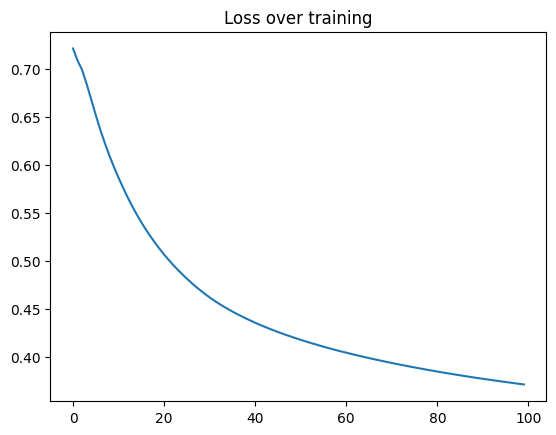

In [6]:
preds = model.predict(tf.convert_to_tensor(x_test))
preds = preds.reshape((preds.shape[0], preds.shape[1]))
results = accuracy_score(preds, y_test)
print(f"Test Accuracy score : {results*100}%")

plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
plt.title("Loss over training")
plt.show()

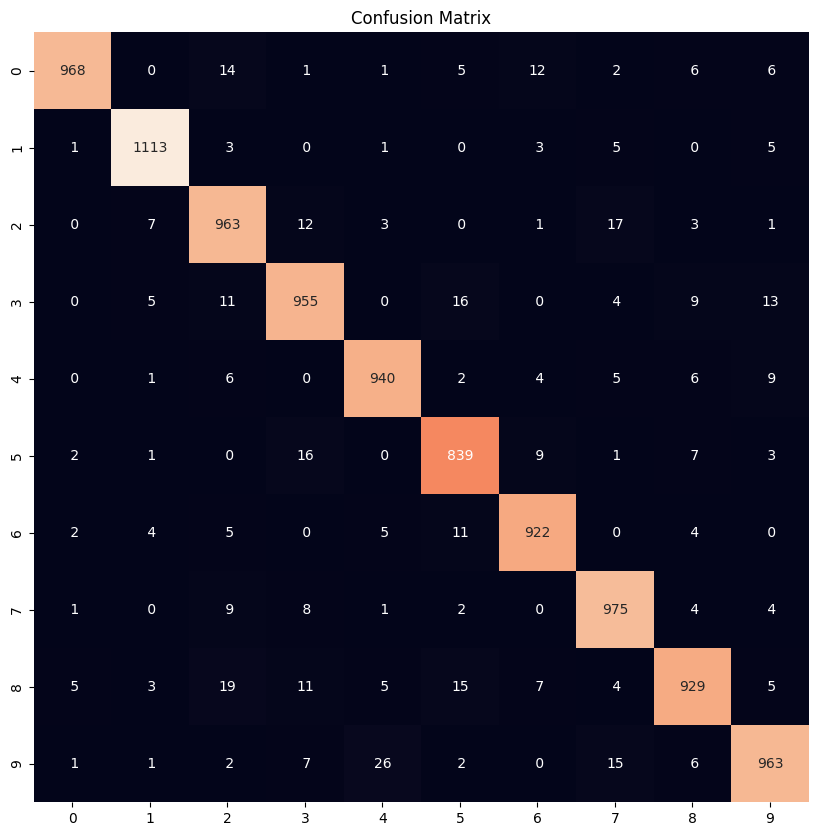

In [14]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(preds, y_test)
sns.heatmap(cm, annot=True, fmt='2d', cbar=False, cmap='rocket')
plt.title('Confusion Matrix')
plt.show()

### Looking at the errors

We can just make a dataframe of all the mismatches, the predicted and actual labels, and sort them

In [15]:
y_hat = np.squeeze(preds)
misses_df = pd.DataFrame(columns=['Predicted', 'Actual'])
misses_df['Predicted'] = y_hat
misses_df['Actual'] = y_test
cond = misses_df['Predicted'] != misses_df['Actual']
misses_df = misses_df[cond]
misses_df = misses_df.sort_values(by=['Predicted', 'Actual'])
misses_df.reset_index(inplace=True)
misses_df = misses_df.rename(columns = {'index':'Example'})

misses_df

,Example,Predicted,Actual
0,421,0,2
1,939,0,2
2,1678,0,2
3,1984,0,2
4,2098,0,2
...,...,...,...
428,2004,9,8
429,4639,9,8
430,6555,9,8
431,7094,9,8


Group by the prediected and actual labels and find the top ten mistakes

In [16]:
misses_df.groupby(['Predicted', 'Actual']).size().sort_values(ascending=False)[:10]

Predicted  Actual
9          4         26
8          2         19
2          7         17
3          5         16
5          3         16
9          7         15
8          5         15
0          2         14
3          9         13
2          3         12
dtype: int64

We can compare the predicted and actual labels for sample of the misclassified images. We may note the ambiguities?

In [17]:
def compare(predicted, actual):
  cond = (misses_df['Predicted'] == predicted) & (misses_df['Actual'] == actual)
  examples = misses_df[cond]['Example']

  samps = random.sample(list(examples), 4)
  imgs = []
  for samp in samps:
    imgs.append((x_test[samp], y_hat[samp], y_test[samp]))

  plt.figure(figsize=(10, 10))
  for idx, item in enumerate(imgs):
      image, predlabel, label = item
      plt.subplot(2, 2, idx + 1)
      plt.imshow(image, cmap="gray")
      plt.title(f"Predicted: {predlabel} Actual: {label}")
  plt.show()


Since mislabeling 4 as 9 is the most common mistake (26 errors out of 10,000 test examples), we can look at a few examples. The ambiguities may be apparent.

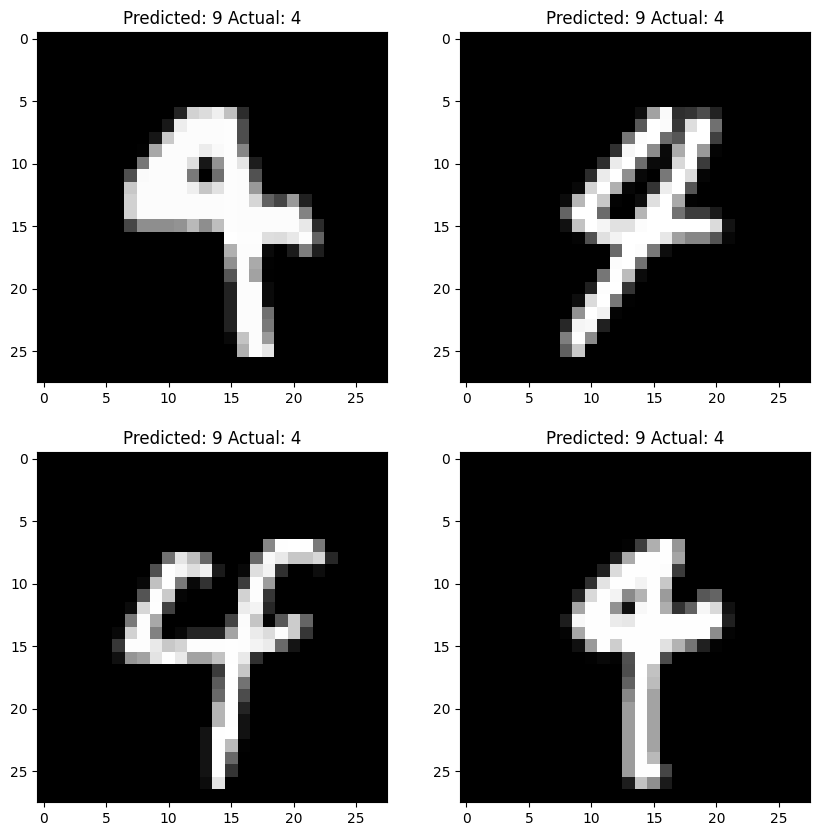

In [18]:
compare(9, 4)

And vice versa

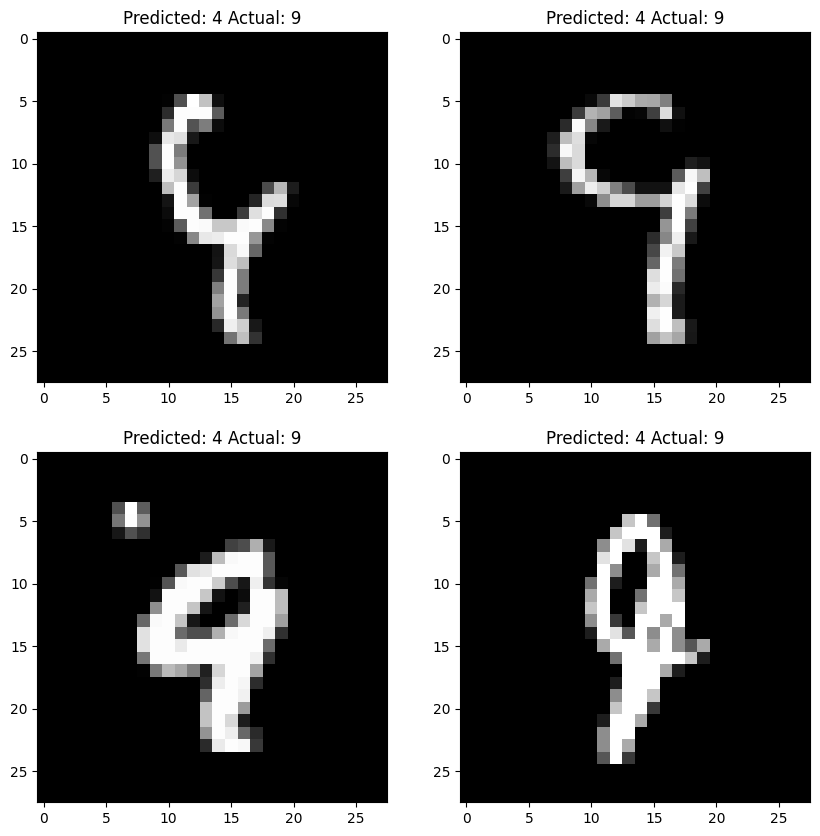

In [19]:
compare(4, 9)

Mistaking 3 for 7 is the least common error in the top ten (only 9 errors)

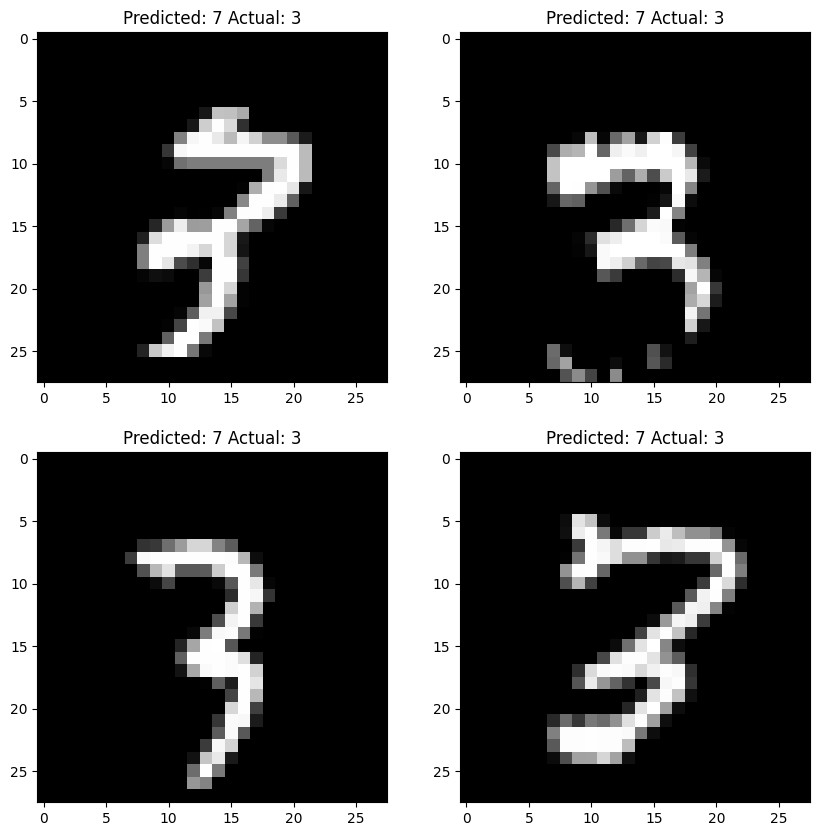

In [20]:
compare(7, 3)